# Prueba #6: Gestión de datos con ElasticSearch y visualización con Matplotlib

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

import pandas as pd

import matplotlib.pyplot as plt

from pprint import pprint

import datetime

import json

import os

In [2]:
es = Elasticsearch()

if not(es.indices.exists(index="p8")):
    res = es.indices.create(index="p8")
    pprint(res)
files = os.listdir("split_tweets")

In [3]:
tweets=[]
def cargarDatos():
    for filename in files:
        with open('split_tweets/'+filename) as f:
            try:
                tweet = json.load(f)
                timestamp = int(tweet["timestamp_ms"])
                simple_tweet = {
                    "timestamp":timestamp,
                    "date":tweet["created_at"],
                    "text": tweet['text'],
                    "username": tweet['user']['name'],
                    "location": tweet['user']['location']
                }
                tweets.append(simple_tweet) 
            except KeyError:
                error="error"



        #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
        if (len(tweets)>=1000):
            i=0
            docs_as_string="["
            while i<1000:
                if i!=0:
                    docs_as_string = docs_as_string + ','
                docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
                i=i+1
            docs_as_string=docs_as_string+"]"
            res = helpers.bulk(es, json.loads(docs_as_string),index="p8",doc_type="_doc")
            tweets=[]

# Preguntas

### En un histograma o en un line plot, visualizar el número de tweets conteniendo la palabra “goal”, cada minuto y cada 10 minutos. (BONUS: gestionar las variantes “goaaal”, “goooaallll”, etc. utilizando expresiones regulares).


In [4]:
#Funcion que transforma el timestamp a time
def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

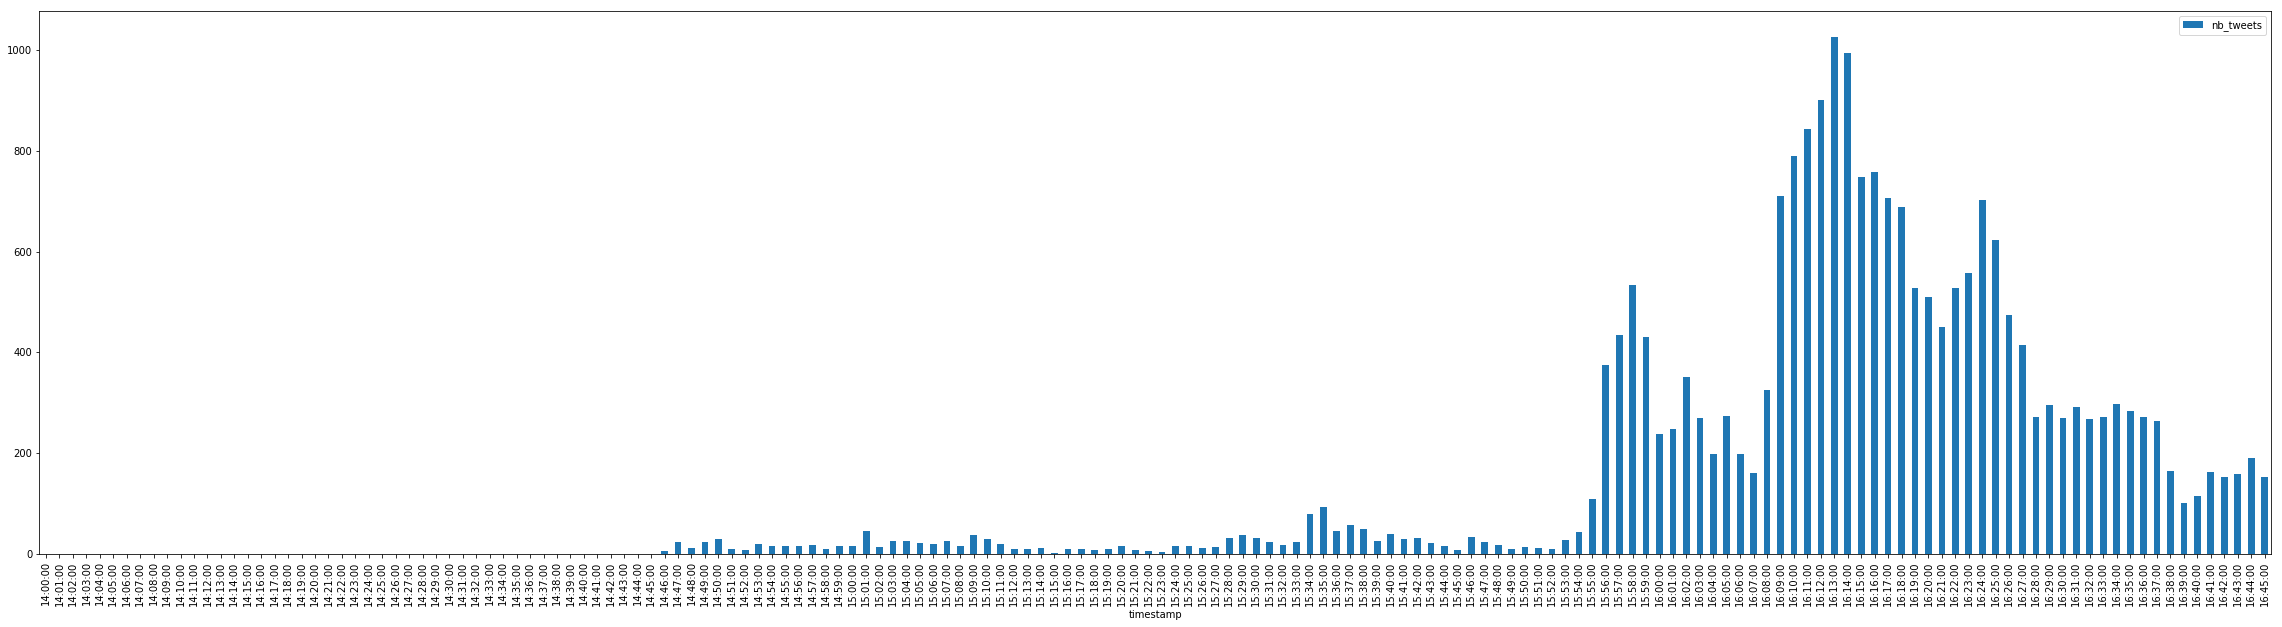

In [5]:
res = es.search(index="p8", 
                body={
                    "query": {
                        "term":{
                            "text":"goal"
                        }
                    },
                    "aggs" : { 
                        "tweets_over_time":{ 
                            "date_histogram":{ 
                                "field" :"timestamp", 
                                "interval" : "1m" 
                            }
                        }
                    }
                }) 
df_goalByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_goalByMinutes = df_goalByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})

## Filtrar Datos
df_goalByMinutes_filtered = df_goalByMinutes.drop(df_goalByMinutes[df_goalByMinutes.timestamp < 1527357600000 ].index)
## Cambiar Dato timestamp a tipo date
df_goalByMinutes_filtered['timestamp']=df_goalByMinutes_filtered['timestamp'].apply(timestamp2date)
## Graficar
df_goalByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

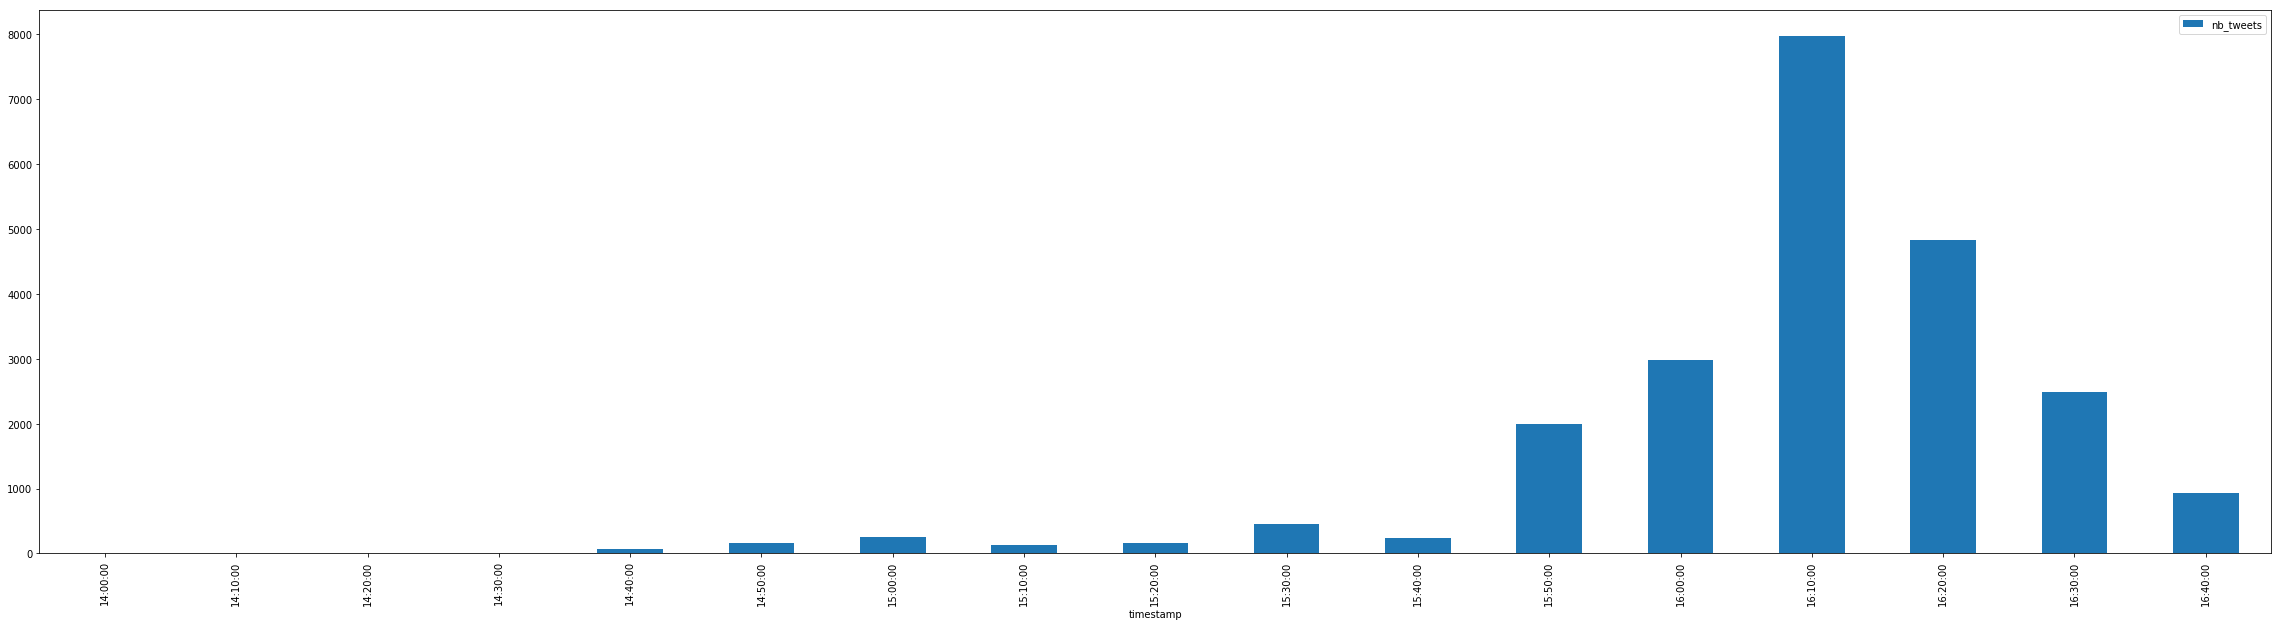

In [6]:
res = es.search(index="p8", 
                body={
                    "query": {
                        "term":{
                            "text":"goal" #<----- Filtrar la palabra Goal 
                        }
                    },
                    "aggs" : { 
                        "tweets_over_time":{ 
                            "date_histogram":{ 
                                "field" :"timestamp", 
                                "interval" : "10m" #<----- 10 Minutos
                            }
                        }
                    }
                }) 
df_10minGol = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_10minGol = df_10minGol.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
## Filtrar Datos
df_10minGol_filtered = df_10minGol.drop(df_10minGol[df_10minGol.timestamp < 1527357600000 ].index)
## Cambiar Dato timestamp a tipo date
df_10minGol_filtered['timestamp']=df_10minGol_filtered['timestamp'].apply(timestamp2date)
## Graficar
df_10minGol_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

# En un histograma o en un line plot, visualizar dos series de datos: 
### el número de tweets que hablan de ‘liverpool’ por cada minuto,
### el número de tweets que hablan de ‘madrid’ por cada minuto.


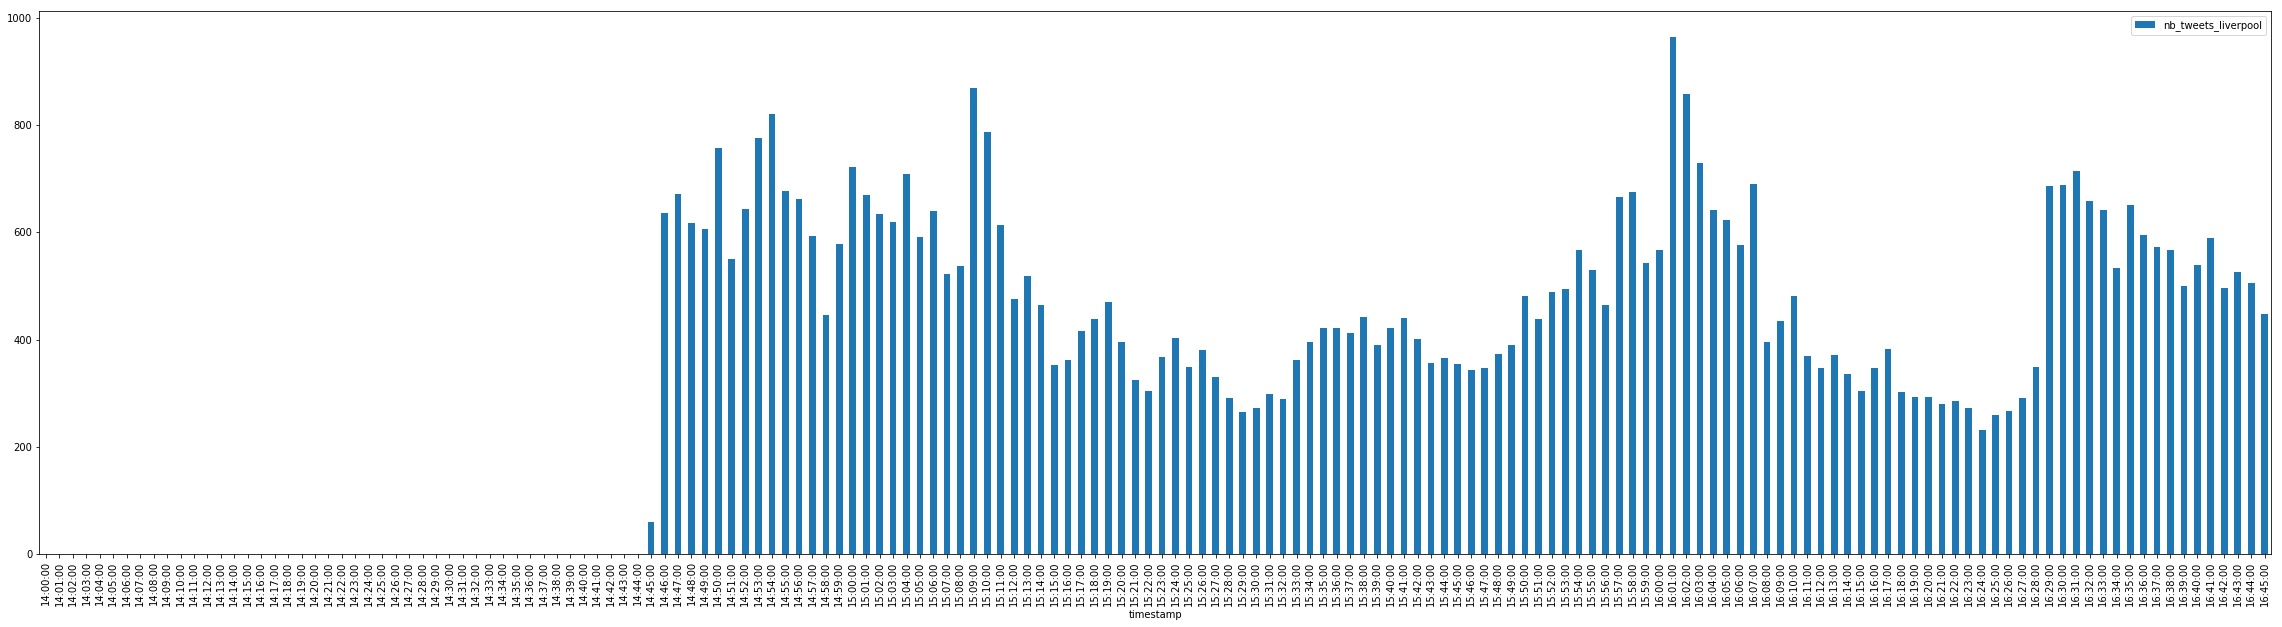

In [7]:
res = es.search(index="p8", 
                body={
                    "query": {
                        "term":{
                            "text":"liverpool" 
                        }
                    },
                    "aggs" : { 
                        "tweets_over_time":{ 
                            "date_histogram":{ 
                                "field" :"timestamp", 
                                "interval" : "1m" 
                            }
                        }
                    }
                }) 
df_liverpoolByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_liverpoolByMinutes = df_liverpoolByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets_liverpool'})
df_liverpoolByMinutes_filtered = df_liverpoolByMinutes.drop(df_liverpoolByMinutes[df_liverpoolByMinutes.timestamp < 1527357600000 ].index)
df_liverpoolByMinutes_filtered['timestamp']=df_liverpoolByMinutes_filtered['timestamp'].apply(timestamp2date)
df_liverpoolByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

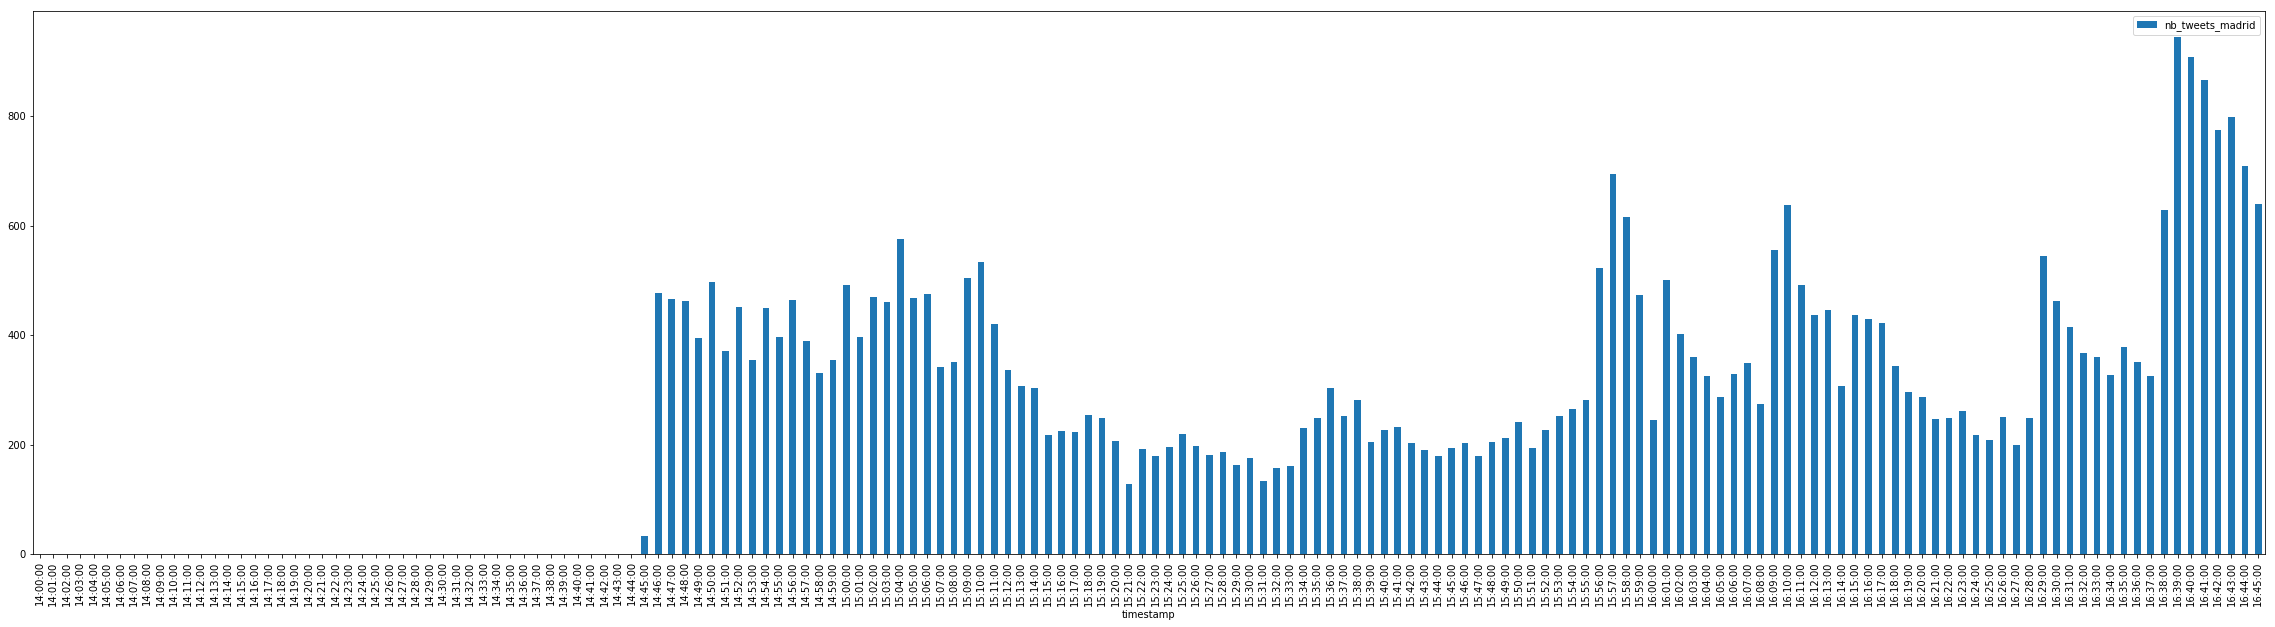

In [8]:
res = es.search(index="p8", 
                body={
                    "query": {
                        "term":{
                            "text":"madrid" 
                        }
                    },
                    "aggs" : { 
                        "tweets_over_time":{ 
                            "date_histogram":{ 
                                "field" :"timestamp", 
                                "interval" : "1m" 
                            }
                        }
                    }
                }) 
df_madridByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_madridByMinutes = df_madridByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets_madrid'})
df_madridByMinutes_filtered = df_madridByMinutes.drop(df_madridByMinutes[df_madridByMinutes.timestamp < 1527357600000 ].index)
df_madridByMinutes_filtered['timestamp']=df_madridByMinutes_filtered['timestamp'].apply(timestamp2date)
df_madridByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

### ¿A qué minuto se habla más de Madrid?


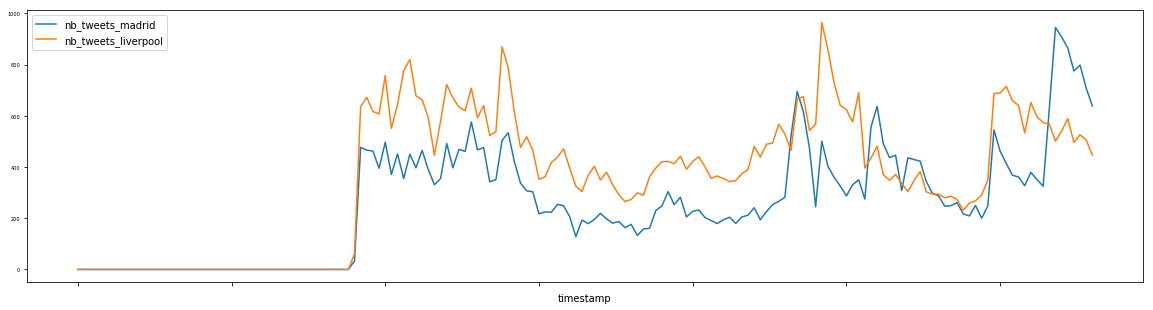

In [9]:
livmad = pd.concat([df_madridByMinutes_filtered, df_liverpoolByMinutes_filtered['nb_tweets_liverpool']], axis=1)
livmad.plot(kind='line', figsize=(20,5), fontsize=5, x='timestamp')

## En un dataframe, mostrar el número de tweets según el país indicado en el campo ‘location’. ¿Desde cuáles países se enviaron los tweets? (BONUS: mostrar los resultados en una mapa).

In [10]:
res = es.search(index="p8", 
                body={
                    "aggs": {
                        "locations": {
                            "terms": {
                                "field": "location.keyword",
                                'size': 354586
                            }
                        }
                    }
                })

df_locations = pd.DataFrame(res['aggregations']['locations']['buckets'])
df_locations

,doc_count,key
0,4733,"Lagos, Nigeria"
1,3403,Nigeria
2,2564,"London, England"
3,2359,"Nairobi, Kenya"
4,2206,South Africa
5,1896,"Johannesburg, South Africa"
6,1575,London
7,1365,United Kingdom
8,1349,Brasil
9,1267,"Rio de Janeiro, Brasil"


# En un histograma o en un line plot, visualizar dos series de datos:
## el número de tweets enviado desde Inglaterra, por cada minuto.
## el número de tweets enviado desde España, por cada minuto.


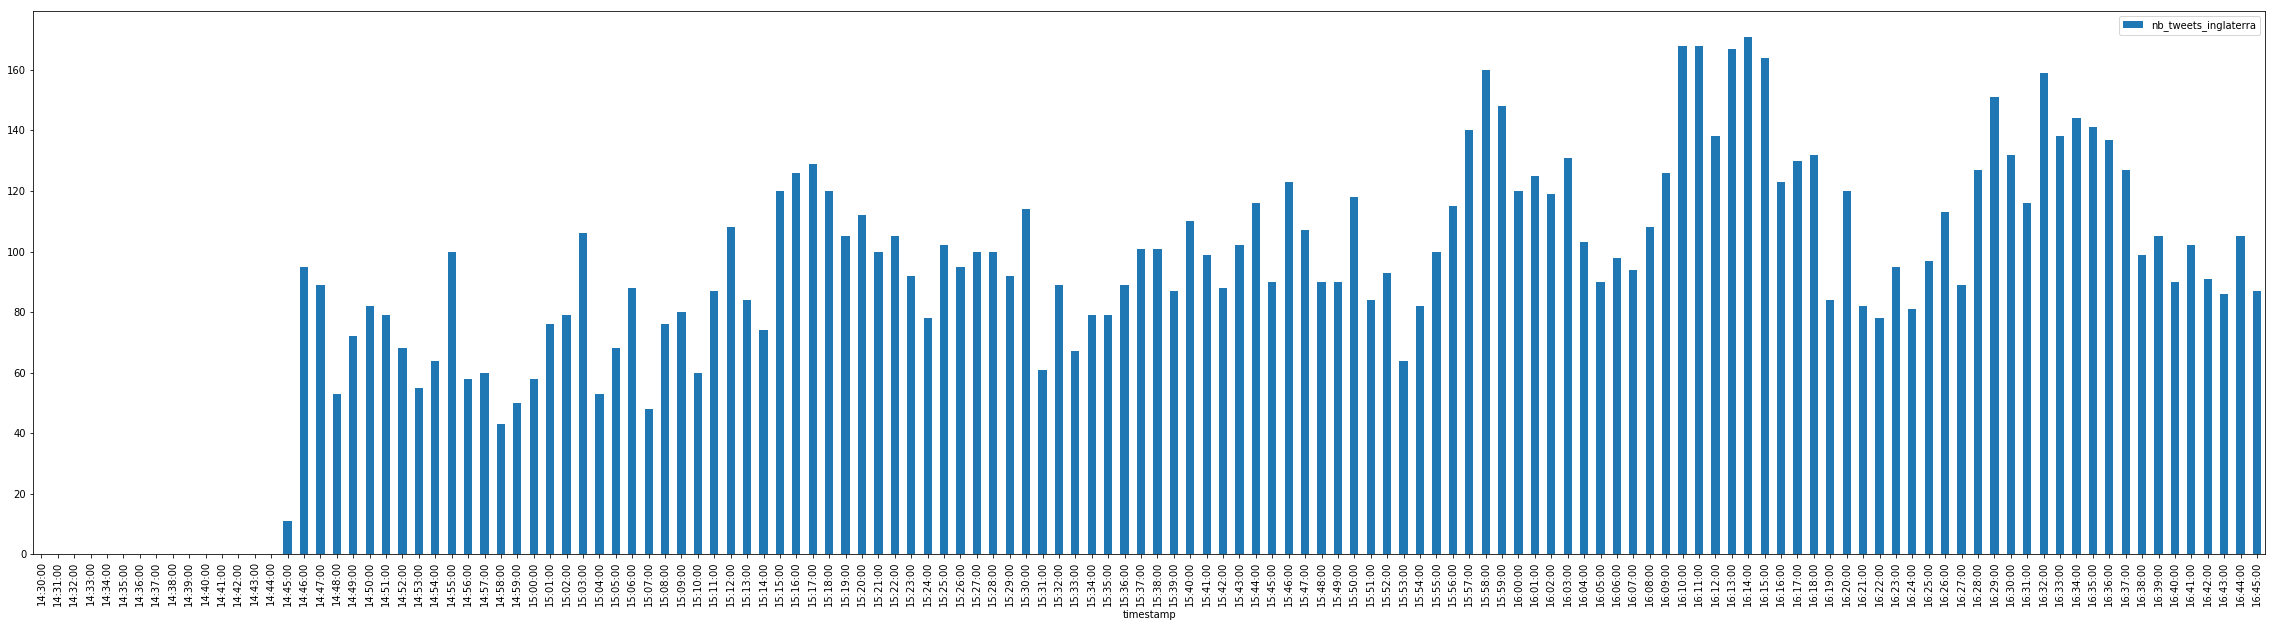

In [11]:
res = es.search(index="p8", 
                body={
                    "query": {
                        "bool":{
                            "should" : [
                                { "term" : { "location" : "inglaterra" } },
                                { "term" : { "location" : "england" } },
                                { "term" : { "location" : "Inglaterra" } },
                                { "term" : { "location" : "England" } }
                              ]
                        }
                    },
                    "aggs" : { 
                        "tweets_over_time":{ 
                            "date_histogram":{ 
                                "field" :"timestamp", 
                                "interval" : "1m" 
                            }
                        }
                    }
                }) 
df_inglaterraByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_inglaterraByMinutes = df_inglaterraByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets_inglaterra'})
df_inglaterraByMinutes_filtered = df_inglaterraByMinutes.drop(df_inglaterraByMinutes[df_inglaterraByMinutes.timestamp < 1527359400000 ].index)
df_inglaterraByMinutes_filtered['timestamp']=df_inglaterraByMinutes_filtered['timestamp'].apply(timestamp2date)
df_inglaterraByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

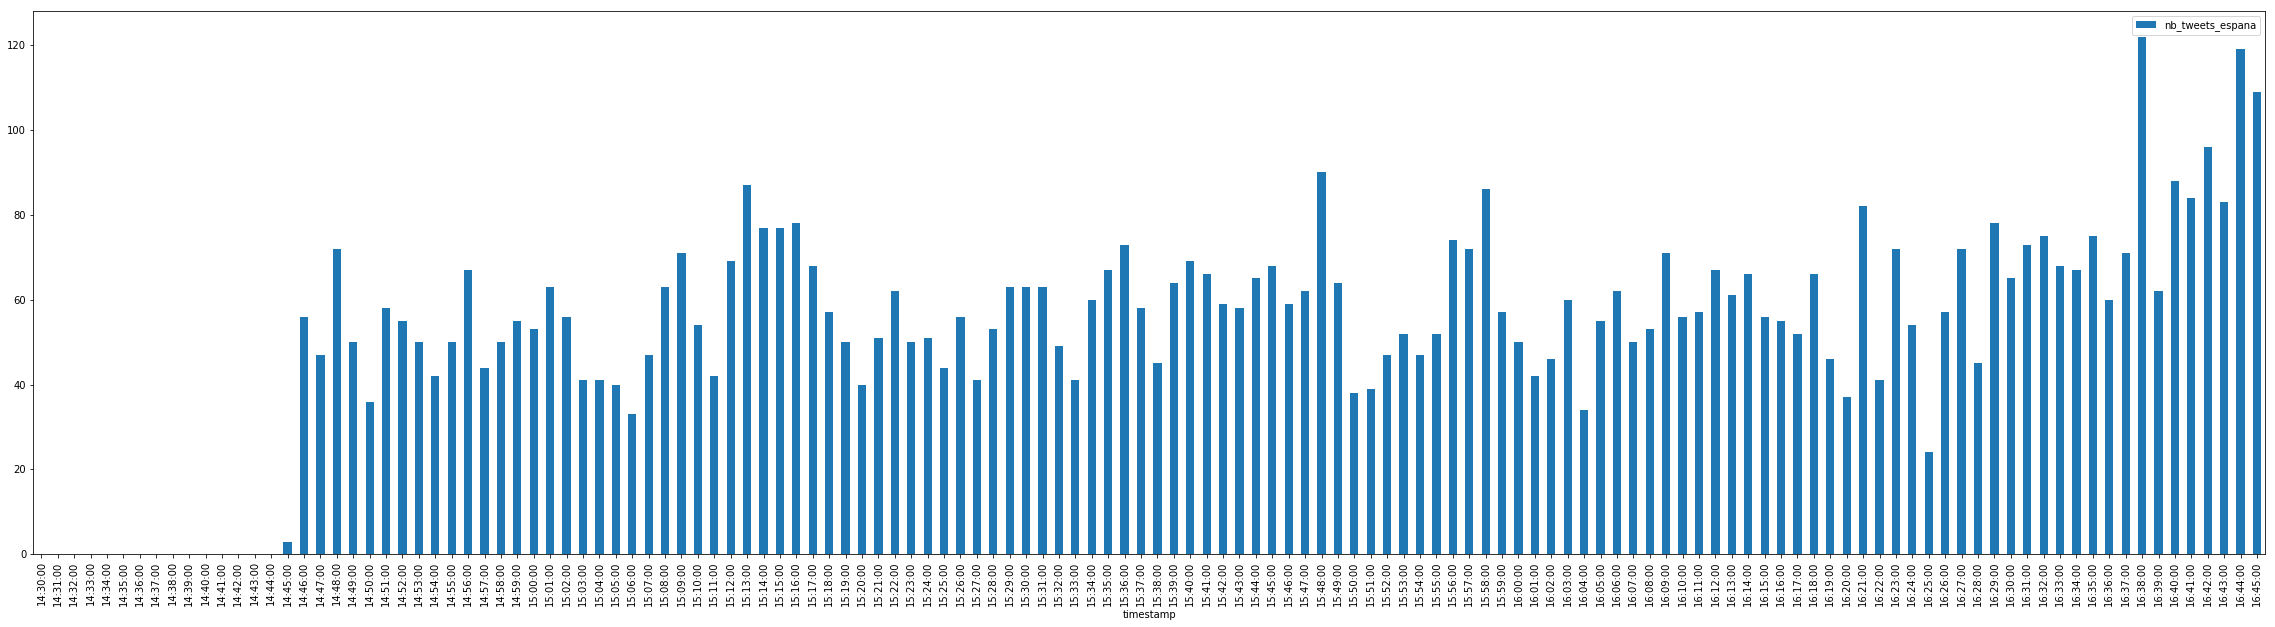

In [13]:
res = es.search(index="p8", 
                body={
                    "query": {
                        "bool":{
                            "should" : [
                                { "term" : { "location" : "españa" } },
                                { "term" : { "location" : "spain" } },
                                { "term" : { "location" : "Spain" } },
                                { "term" : { "location" : "Espana" } }
                              ]
                        }
                    },
                    "aggs" : { 
                        "tweets_over_time":{ 
                            "date_histogram":{ 
                                "field" :"timestamp", 
                                "interval" : "1m" 
                            }
                        }
                    }
                }) 
df_espanaByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_espanaByMinutes = df_espanaByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets_espana'})
df_espanaByMinutes_filtered = df_espanaByMinutes.drop(df_espanaByMinutes[df_espanaByMinutes.timestamp < 1527359400000 ].index)
df_espanaByMinutes_filtered['timestamp']=df_espanaByMinutes_filtered['timestamp'].apply(timestamp2date)
df_espanaByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

## ¿Cómo podríamos analizar las emociones expresadas durante el partido? Proponer una metodología para responder a esta pregunta. (No es obligatorio implementar su metodología pero debe ser factible con las tecnologías que conocen).

#### Ver palabras que expresen alguna emocion, quizas clasificar palabras como negativas o positivas, al igual que los emojis, despuer ver en el tweet si contiene mas palabras positivas que negativas, lo mismo con los emojis